In [114]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Colors to show wins vs losses.
color_mapping = {"W":"seagreen",
                 "L":"#C8102E"}

sns.set_style("darkgrid")

In [5]:
playsData = pd.read_csv('../OnlyClippersPlays.csv',index_col=0)
gamesData = pd.read_csv('../ClippersSchedule2425.csv',index_col=0)

In [6]:
# We convert the PLAYED_TIME string column (03:24) into a int column with the seconds played (204)
playsData['PLAYED_TIME'] = pd.to_timedelta(playsData['PLAYED_TIME']).dt.total_seconds()
playsData.head()

,Unnamed: 0,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PLAYED_TIME,LAC_SCORE
1,21,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,TIE,122.0,2
3,23,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,TIE,150.0,4
5,33,22401036,1,1,7:55,Zubac 7' Driving Hook Shot (6 PTS) (Harden 1 AST),NaN,NaN,7 - 6,-1,245.0,6
7,35,22401036,1,1,7:16,Dunn 8' Driving Floating Jump Shot (2 PTS) (Ha...,NaN,NaN,9 - 8,-1,284.0,8
9,40,22401036,1,1,6:26,Dunn 10' Driving Floating Jump Shot (4 PTS) (L...,NaN,NaN,12 - 10,-2,334.0,10


In [7]:
gamesData = gamesData.sort_values('GAME_DATE')

def trackWL(gamesData):
    # Function to track the historic wins and defeats throguh the season after each game. 
    wins, defeats = 0, 0
    winsList,  defeatsList,  pct = [], [], []

    for iGame in range(len(gamesData)):
        if gamesData.iloc[iGame]['WL'] == 'W':
            wins += 1
        else:
            defeats += 1
        winsList.append(wins)
        defeatsList.append(defeats)
        pct.append(wins/(wins+defeats))

    gamesData['WINS'] = winsList
    gamesData['DEFEATS'] = defeatsList
    gamesData['PCT'] = pct
    return gamesData


gamesData = trackWL(gamesData)


months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

gamesData['GAME_DATE'] = pd.to_datetime(gamesData['GAME_DATE'])
gamesData['GAME_MONTH'] = gamesData['GAME_DATE'].apply(lambda x: months[x.month - 1])


# 1. History of PCT Win during the Season

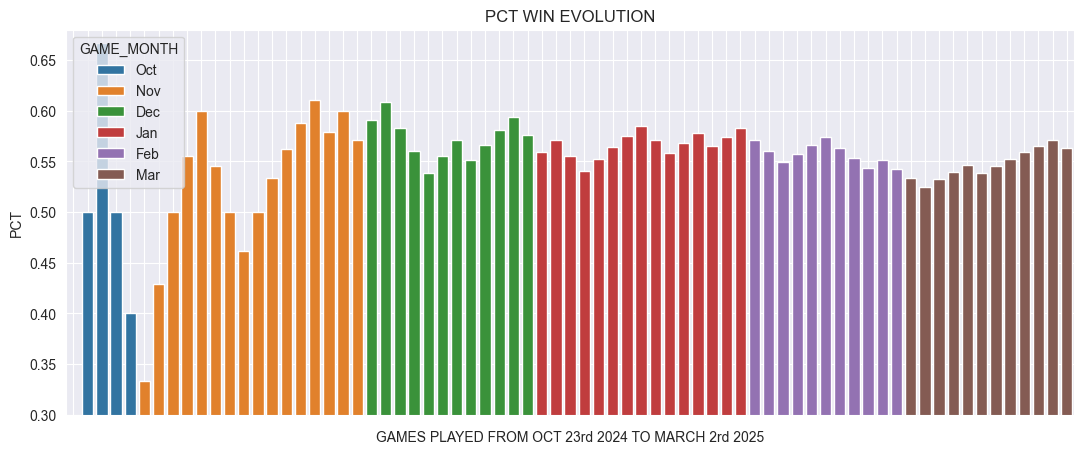

In [8]:
plt.figure(figsize=(13, 5))

sns.barplot(x="GAME_DATE",y="PCT",hue="GAME_MONTH",data=gamesData, legend=True)


plt.ylim(0.3,0.68)
plt.gca().set_xticklabels([])
plt.title('PCT WIN EVOLUTION')
plt.xlabel('GAMES PLAYED FROM OCT 23rd 2024 TO MARCH 2rd 2025')
plt.grid(True)
plt.show()

# 2. Points Scored (Wins vs Losses)

In [9]:
gamesData['GAME_COLOR'] = gamesData['WL'].map(color_mapping)

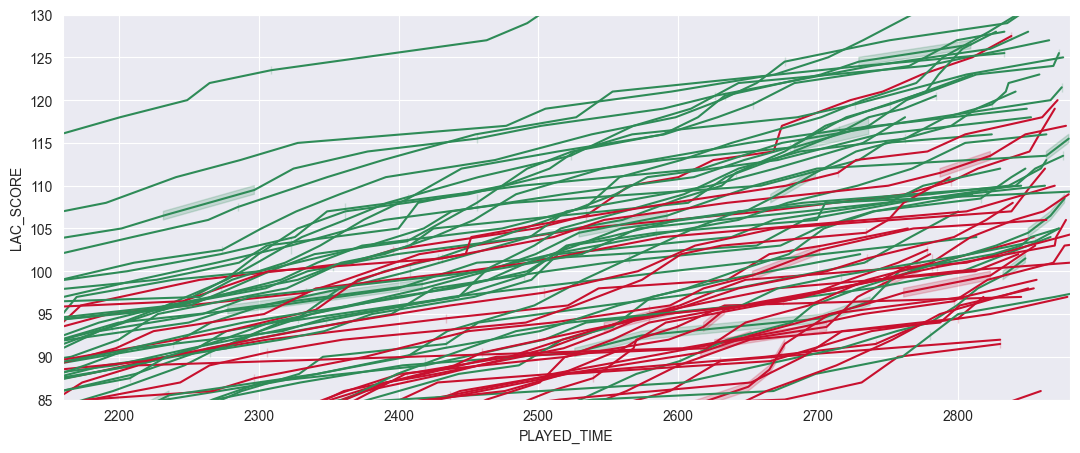

In [10]:
plt.figure(figsize=(13, 5))

game_colors = dict(zip(gamesData['GAME_ID'], gamesData['GAME_COLOR']))

sns.lineplot(playsData, x="PLAYED_TIME",y="LAC_SCORE",hue="GAME_ID", palette=game_colors,legend=False)
plt.ylim(85,130)
plt.xlim(2160,2880)
plt.grid(True)

### 2.2 +/- for each quarter

In [68]:
plays = pd.read_csv('../ClippersGamesPlays.csv',index_col=0)
plays['SCOREMARGIN'] = plays['SCOREMARGIN'].apply(lambda x: 0 if x=="TIE" else int(x))
plays.head()


,GAME_ID,EVENTMSGTYPE,PERIOD,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN
14,22401036,1,1,10:37,NaN,NaN,Hartenstein 1' Cutting Dunk Shot (2 PTS) (Gilg...,2 - 0,-2
21,22401036,1,1,9:58,Zubac Putback Dunk (2 PTS),NaN,NaN,2 - 2,0
22,22401036,1,1,9:50,NaN,NaN,Hartenstein 2' Cutting Layup Shot (4 PTS) (Gil...,4 - 2,-2
23,22401036,1,1,9:30,Zubac 3' Driving Reverse Layup (4 PTS),NaN,NaN,4 - 4,0
32,22401036,1,1,8:10,NaN,NaN,Wallace 26' 3PT Jump Shot (3 PTS) (Hartenstein...,7 - 4,-3


In [80]:
netRatingGames = pd.DataFrame(columns=["GAME_ID","PERIOD","INITIAL_SCORE","END_SCORE","NET_RATING_PERIOD"])

def calculateNetRating(quarter,plays):
    netRating = []
    
    for game in plays['GAME_ID'].unique():
        quarterData = plays[(plays['GAME_ID']==game) & (plays['PERIOD']==quarter)]
        if quarter == 1:
            initialScore = 0
        else:
            initialScore = quarterData.iloc[0]['SCOREMARGIN']
        
        endScore = quarterData.iloc[-1]['SCOREMARGIN']
        netRating = int(endScore) - int(initialScore)

        data = [game, quarter, initialScore, endScore, netRating]
        netRatingGames.loc[len(netRatingGames)] = data

for i in range(1,5): calculateNetRating(i,plays)

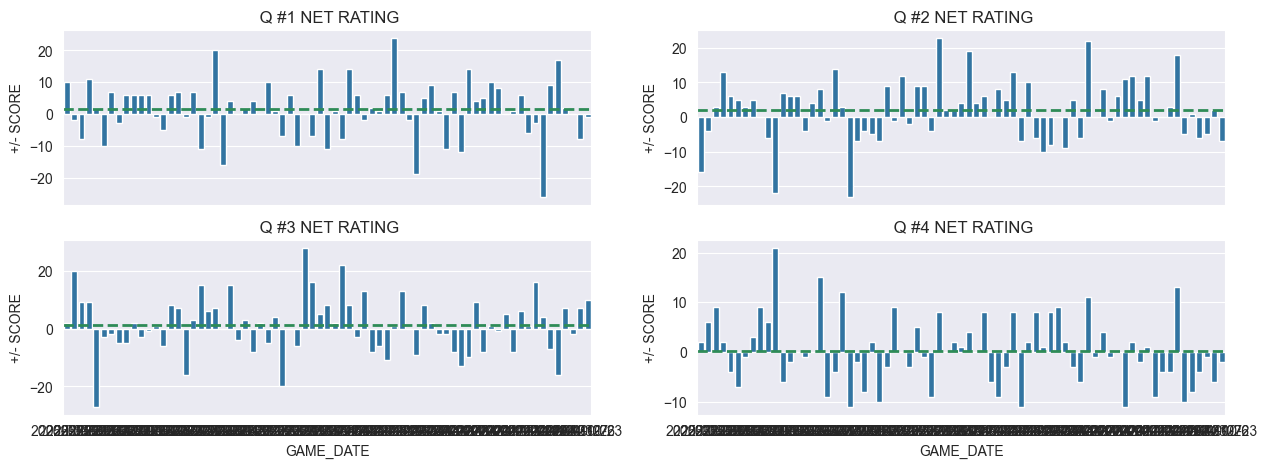

In [151]:
gameColumns = ['GAME_ID','GAME_DATE','MATCHUP','WL','PLUS_MINUS']
result = pd.merge(left=netRatingGames,right=gamesData[gameColumns],on="GAME_ID")

fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,5))

for i in range(1,5):
    row, col = divmod(i - 1, 2)
    
    sns.barplot(ax=axes[row, col], data=result[result['PERIOD']==i],x="GAME_DATE",y="NET_RATING_PERIOD")

    mean = np.mean(result[result['PERIOD']==i]['NET_RATING_PERIOD'])
    
    axes[row, col].set_title(f" Q #{i} NET RATING")
    axes[row,col].axhline(mean, color='seagreen', linestyle='--', linewidth=2)
    axes[row,col].set_ylabel("+/- SCORE")
    

# 3. Players Performance

In [12]:
def extractPlay(HOME,VISITOR): return VISITOR if pd.isna(HOME) else HOME

playsData['LAC_PLAYS'] = playsData.apply(lambda x: extractPlay(x['HOMEDESCRIPTION'] , x['VISITORDESCRIPTION']),axis=1)
playsData['SCOREMARGIN'] = playsData['SCOREMARGIN'].apply(lambda x: 0 if x=="TIE" else int(x))
HardenSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Harden')]
LeonardSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Leonard')]
PowellSM = playsData[playsData['LAC_PLAYS'].str.split(' ').apply(lambda x: x[0]=='Powell')]

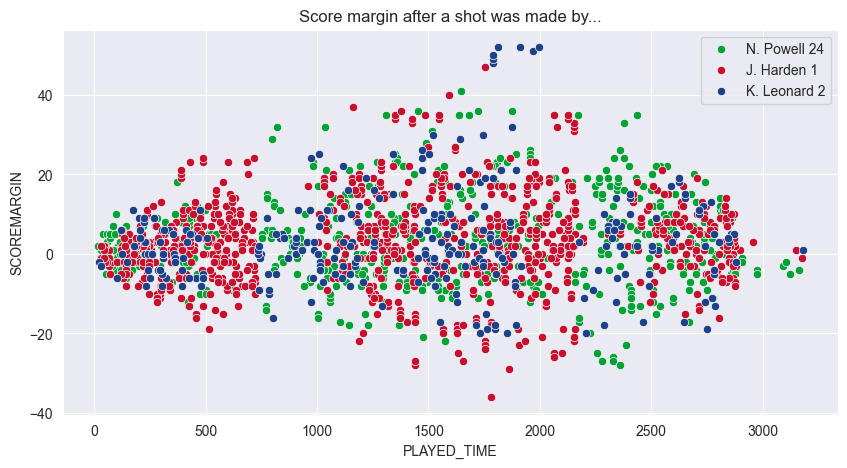

In [13]:
plt.figure(figsize=(10, 5))

sns.scatterplot(data=PowellSM,x="PLAYED_TIME",y="SCOREMARGIN",label="N. Powell 24",color="#00a135")
sns.scatterplot(data=HardenSM,x="PLAYED_TIME",y="SCOREMARGIN",label="J. Harden 1",color="#c8102E")
sns.scatterplot(data=LeonardSM,x="PLAYED_TIME",y="SCOREMARGIN",label="K. Leonard 2",color="#1d428a")
plt.title("Score margin after a shot was made by...")
plt.legend()

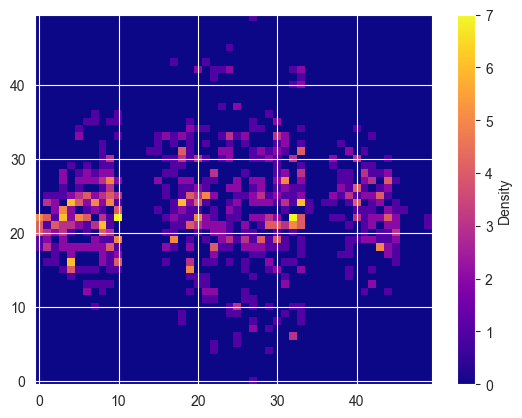

In [14]:
import numpy as np

heatmap, xedges,yedges = np.histogram2d(HardenSM["PLAYED_TIME"],HardenSM["SCOREMARGIN"], bins=50)
plt.imshow(heatmap.T, origin='lower',cmap='plasma',aspect='auto')
plt.colorbar(label='Density')